# Overlap in Lexical and Literary Vocabulary

Comparing the vocabulary of Old Babylonian lexical texts (from Nippur) and the vocabulary of the Sumerian literary corpus as represented in [ETCSL](http://etcsl.orinst.ox.ac.uk/).

## 0 Preparation 
In order to run this notebook, parse the [DCCLT](http://oracc.org/dcclt) data with the Extended ORACC Parser (2.3.3) and the [ETCSL](http://etcsl.orinst.ox.ac.uk) data with the ETCSL Parser (2.4).

In [2]:
%matplotlib inline
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import tqdm
import re
import zipfile
import json

### 0.1 Read ETCSL Data Files
Open the file `alltexts.csv` which contains all the [ETCSL](http://etcsl.orinst.ox.ac.uk) and read the data into a `Pandas`DataFrame. Each row is a word from [ETCSL](http://etcsl.orinst.ox.ac.uk/) in lemmatized format, according to [ePSD2](http://build-oracc.museum.upenn.edu/epsd2) standards.

In [3]:
file = "../2_4_Data_Acquisition_ETCSL/Output/alltexts.csv"
etcsl = pd.read_csv(file, keep_default_na=False)
etcsl = etcsl.loc[etcsl["lang"].str.contains("sux")]  # throw out non-Sumerian words

### 0.2 Lemmas
Create a lemmas column and lowercase all lemmas.

In [4]:
etcsl["lemma"] = etcsl.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
etcsl['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in etcsl['lemma'] ] 
# kick out empty forms
etcsl["lemma"] = etcsl["lemma"].str.lower()

### 0.3 Read Lexical Data

Essentially following the same process as in the preceding cells.

In [5]:
file = "../2_3_Data_Acquisition_ORACC/output/parsed.csv"
lexical = pd.read_csv(file, keep_default_na=False)
lexical = lexical.loc[lexical["lang"].str.contains("sux")]

In [6]:
lexical["lemma"] = lexical.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
lexical['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in lexical['lemma'] ] 
# kick out empty forms
lexical["lemma"] = lexical["lemma"].str.lower()

In [7]:
lexical = lexical[~lexical["field"].isin(["sg", "pr"])] # remove lemmas that derive from the fields "sign" 
# or "pronunciation" in sign lists.

### 0.4 Select Old Babylonian Texts

In [8]:
file = "../2_3_Data_Acquisition_ORACC/jsonzip/dcclt.zip"
z = zipfile.ZipFile(file) 
st = z.read("dcclt/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
cat_df = cat_df[["id_text", "period"]]

In [9]:
ob = cat_df[cat_df["period"] == "Old Babylonian"]

In [10]:
keep = ob.index.values
keep = ['dcclt/' + id_text for id_text in keep]
lexical = lexical.loc[lexical["id_text"].isin(keep)]

## 1 First Approximation
Extract the vocabulary of ETCSL and the lexical texts, counting each lemma separately. Thus, in the lexical item `gud an-na` we include the words `gud` (ox) and `an` (heaven) separately to see if those words appear in the literary corpus as well. This approach, therefore, does not look specificaly for attestations of the phrase `gud an-na` in both corpora.

In [11]:
etcsl_words_s = set(list(etcsl["lemma"]))
lexical_words_s = set(list(lexical["lemma"]))
etcsl_words_s = {lemma for lemma in etcsl_words_s if not '[na]na' in lemma}
lexical_words_s = {lemma for lemma in lexical_words_s if not '[na]na' in lemma}

In [12]:
def plot_venn(lit_vocab, lex_vocab):
    """The function takes two sets and draws a Venn diagram that shows the intersection between the two sets.
    The legend includes the length of each set and the percentage of the intersection with the other set.
    """
    plt.figure(figsize=(8,8))
    lit_abs = len(lit_vocab)
    lex_abs = len(lex_vocab)
    inter_abs = len(lit_vocab.intersection(lex_vocab))
    lit_per = "{:.0%}".format(inter_abs/lit_abs)
    lex_per = "{:.0%}".format(inter_abs/lex_abs)
    lit_legend = "literary (" + str(lit_abs) + ') ' + lit_per + " overlap"
    lex_legend = "lexical (" + str(lex_abs) + ') ' + lex_per + " overlap"
    c = venn2([lit_vocab, lex_vocab], (lit_legend, lex_legend))
    c.get_patch_by_id('10').set_color("#fdb515")
    c.get_patch_by_id('01').set_color("#003262")
    c.get_patch_by_id('11').set_color("#bc9b6a")
    plt.show()
    return

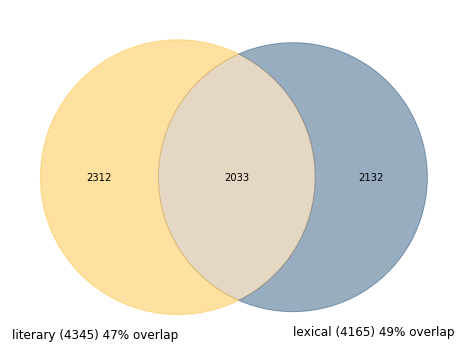

In [13]:
plot_venn(etcsl_words_s, lexical_words_s)

## 2 Second Approach: Multiple Word Expressions

Instead of looking at individual words (or lexemes), we may also look at lexical *entries* and their appearance (or not) in literary texts. The list of domestic animals, for instance, includes the entry `udu dijir-e gu₇-a`('sheep eaten by a god'), lemmatized as `udu[sheep]n diŋir[god]n gu[eat]v/t`. Unsurprisingly, all these very common lemmas appear in the literary corpus, and thus in our previous analysis this item results in three hits. But does the expression as a whole ever appear in the literary corpus? 

In order to perform the comparison on the lexical entry level we first need to represent our data (lexical and literary) as lines, rather than as individual words.


### 2.1 Line by Line

The dataframe `lexical` that was produced in section 0.4 contains the lemmatizations of all Old Babylonian lexical texts in a word-by-word (or rather lemma-by-lemma) arrangement. In order to work with lexical *entries* we need to reconstruct lines. That is, we collect the words (lemmas) that belong to the same line of the same lexical text. The dataframe `lexical` includes the fields `id_text` and `id_line` that allow us to do so. We want to change a series of entries like this:

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | udu\[sheep\]n |
| dcclt/Q000001|	1 | niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	udu\[sheep\]n|
| dcclt/Q000001|	2 |	niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	sag\[rare\]v/i|

Into a single entry (representing a single line in a lexical text) like this:

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | udu\[sheep\]n niga\[fattened\]v/i |
| dcclt/Q000001|	2 | udu\[sheep\]n niga\[fattened\]v/i sag\[rare\]v/i |

In order to do this we use the Pandas functions `groupby()` and `agg()` (for aggregate). The `groupby()` function takes as argument a list of fields on which the grouping should be performed, in this case the fields `id_text` and `id_line`. The `agg()` function, in addition, indicates which columns of the dataframe (beside `id_text` and `id_line`) are kept and how they are treated when grouped (see also 2.3.???). The `groupby()` function turns the dataframe into a so-called "GroupBy object" which preserves all the information of the original dataframe but cannot be as nicely displayed. The GroupBy object can be further manipulated with the `agg()` function.

The `agg()` function works on a GroupBy object and computes summary statistics (such as mean, sum, or average) for each group. In our case each group is a line in a lexical text and the "summary statistics" that we want is simply the concatenation of all the strings values in the `lemma` column. The `agg()` function takes as argument a dictionary with a field name as key and a function as value. The function `' '.join` joins the elements in the `lemma` column separated by a space. A second field that is aggregated is `extent`. This field indicates the number of broken or illegible lines between two lines of text. We will use that data in a later phase of the analyis.

The combination of `groupby()` and `agg()` creates a new dataframe with a composite index. The Pandas function `reset_index()` will create a new index that starts counting from 0.

In [ ]:
lexical = lexical.groupby([lexical['id_text'], lexical['id_line']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    }).reset_index()

In [15]:
lexical[:10]

,id_text,id_line,lemma,extent
0,dcclt/P117394,2,kid[mat]n,
1,dcclt/P117394,3,kid[mat]n andul[shade]n,
2,dcclt/P117394,4,kid[mat]n antadul[cloak]n,
3,dcclt/P117395,2,ŋešed[key]n,
4,dcclt/P117395,3,pakud[~tree]n,
5,dcclt/P117395,4,raba[clamp]n,
6,dcclt/P117396,2,hašhur[apple]n,
7,dcclt/P117396,3,hašhur[apple]n baza[dwarf]n,
8,dcclt/P117396,4,hašhur[apple]n mari[1]sn,
9,dcclt/P117397,2,laqipu[1]dn,


Now we do essentially the same for the `etcsl` dataframe, reconstructing lines in literary compositions.

In [ ]:
etcsl = etcsl.groupby([etcsl['id_text'], etcsl['id_line'], etcsl['text_name']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    }).reset_index()

In [19]:
etcsl[1000:1010]

,id_text,id_line,text_name,lemma,extent
1000,c.1.1.3,51,Enki and the world order,x[na]na x[na]na x[na]na en[lord]n uŋ[people]n ...,
1001,c.1.1.3,52,Enki and the world order,aya[father]n enki[1]dn uŋ[people]n numun[seed]...,
1002,c.1.1.3,53,Enki and the world order,nudimmud[1]dn u[ewe]n zid[right]v/i ŋa₂[na]na ...,
1003,c.1.1.3,54,Enki and the world order,ab[cow]n numun[seed]n e[leave]v/i amar[young]n...,
1004,c.1.1.3,55,Enki and the world order,uzud[goat]n zid[right]v/i ŋa₂[na]na e[leave]v/...,
1005,c.1.1.3,56,Enki and the world order,gana[field]n gana[field]n zid[right]v/i ŋa₂[na...,
1006,c.1.1.3,57,Enki and the world order,gurudud[heap]n gurumaš[heap]n aneden[steppe]n ...,
1007,c.1.1.3,58,Enki and the world order,kalam[land]n ki[place]n tab[burn]v/t e[leave]v/i,
1008,c.1.1.3,60,Enki and the world order,x[na]na x[na]na,
1009,c.1.1.3,61,Enki and the world order,enki[1]dn lugal[king]n abzu[water]n ni[fear]n ...,


### 2.2 Extract lexical entries 
Each row in the resulting DataFrame `lexical` now consists of a text ID (`id_text`), a line number (`id_line`), and the lemmas that represent a lexical *entry* (e.g. `udu[sheep]n diŋir[god]n gu[eat]v/t`). We extract the `lemma` column, remove duplicate lexical entries with the `set()` function and create a `list`. 

In [23]:
lex_vocab = list(set(lexical["lemma"]))
#lex_vocab = [item.replace(" ", "*") for item in lex_vocab]
lex_vocab[0:20]

['x[na]na bu[na]na',
 '{d}lugal-me-šu-du₇[na]na',
 '{d}nin-sar[na]na',
 'lu₂[na]na igi[na]na duh[na]na lal-a[na]na',
 'ba[tool]n zu[stone]n',
 'sullim[spice]n x{sar}[na]na',
 'zadim[na]na',
 'da-ri[na]na',
 'akkil-akkil[na]na',
 '{ŋeš}gan-la[na]na',
 'gan₂-il₂[na]na',
 'girinum[plant]n',
 'saŋšu[turban]n x[na]na x[na]na',
 'x[na]na ne[na]na',
 'sipad[na]na e₂-kur-re[na]na ki-aŋ₂[na]na',
 '{gi}ig-guru₅-uš[na]na',
 'sur[na]na',
 'šag[heart]n',
 'hiz[vegetable]n dug[good]v/i',
 'zumdianum[tree]n']

## Mark lexical entries in literary texts
The list `lex_vocab` now contains all unique lexical entries in the Old Babylonian corpus as edited in [DCCLT](http://oracc.org/dcclt). This is the vocabulary that we wish to find in the literary corpus as edited in [ETCSL](http://etcsl.orinst.ox.ac.uk/).

In order to do so we will first sort the list `lex_vocab` by string length, so that the longest item comes first. We now iterate through the list and check to see if the item contains multiple lemmatizations (contains spaces). If so, we will search for identical sequences of lemmas in the `etcsl` dataframe and connect those lemmas with asterisks.

We will do this with the Pandas function `str.replace()`. This function takes two arguments: the string to be replaced, and the replacement string. By default, `str.replace()` uses [regular expression](https://www.regular-expressions.info/), so that a string like `udu[sheep]n` is interpreted as "any string that begins with "udu" followed by one of the characters in "\[sheep\]" followed by "n". This is obvioously not what we want (the search will most likely find zero strings to replace). We can avoid this behaviour by "escaping" the special characters (preceding them with a backslash). The function `escape()` from the `re` (regular expression) library will do that.

Now we create a variable `replacewith` that is identical with the lexical item, but has its spaces replaced by asterisks. Finally we run the `str.,replace

In each matching string in the `etcsl` dataframe we replace the spaces (separating the individual lemmas) by asterisks, thus marking those adjacent words as belonging to a single lexical entry.


In order to do so we create a `findwhat` variable that is derived from the lexical item. First the asterisks are replaced again by spaces (we are looking for, say, `udu[sheep]n diŋir[god]n gu[eat]v/t`). Second, all characters that are interpreted as [regular expression](https://www.regular-expressions.info/) special characters (such as square brackets) need to be escaped (prefixed by a backslash), so that they are interpreted as literals by the `str.replace()` function. 

The `str.replace()` function takes a considerable amount of time. It has to check each line in [ETCSL](http://etcsl.orinst.ox.ac.uk/) (almost 36.500 lines) against each lexical entry (almost 6,000 entries). The progress bar follows the progress through the list of lexical entries.

The `lemma` column of the `etcsl` dataframe will now represent the [ETCSL](http://etcsl.orinst.ox.ac.uk/) data in a line-by-line presentation of lemmatizations, with asterisks connecting lemmas if a corresponding sequence of lemmas exists as a lexical entry.

In [ ]:
lex_vocab.sort(key=len, reverse=True)
for item in tqdm.tqdm(lex_vocab):
    if " " in item:
        findwhat = re.escape(item)
        replacewith = item.replace(" ", "*")
        etcsl["lemma"] = etcsl["lemma"].str.replace(findwhat, replacewith)

In [ ]:
etcsl_words2 = ' '.join(list(etcsl["lemma"]))
etcsl_words_s2 = set(etcsl_words2.split())
lexical_words_s2 = set(list(lexical["lemma"]))
etcsl_words_s2 = {lemma for lemma in etcsl_words_s2 if not '[na]na' in lemma}
lexical_words_s2 = {lemma for lemma in lexical_words_s2 if not '[na]na' in lemma}

In [ ]:
plot_venn(etcsl_words_s2, lexical_words_s2)

# Add them Up
By creating the union of the two sets (the set with individual words and the set with the lexical entries only) we get the most complete comparison of the two corpora. Here `gud[oxen]N*an[heaven]N`, `gud[oxen]N` and `an[heaven]N` are all counted as words, whether or not `gud` and `an` actually appear as such in the lexical corpus.

It turns out that this addition adds only twenty words to the literary vocabulary. These are words that appear in lexical expressions (connected by \*), but never appear on their own outside such expressions. The lexical corpus has more of those lexemes: more than 700; about half of those also appear in the literary corpus, increasing the overlap by about 370.

In [ ]:
etcsl_words_s3 = etcsl_words_s | etcsl_words_s2
lexical_words_s3 = lexical_words_s | lexical_words_s2

In [ ]:
plot_venn(etcsl_words_s3, lexical_words_s3)

# Create a Corpus
The etcsl dataframe is organized by line. The `aggregate` function assembles the lines that belong to a single composition. The resulting dataframe has 394 entries, one for each composition. 

In [ ]:
corpus = etcsl.groupby([etcsl["etcsl_no"], etcsl["text_name"]]).aggregate({"text": " ".join}).reset_index()

# Document Term Matrix
The corpus is transformed into a Document Term Matrix (or DTM) in which each word (or expression) is a column and each row a Sumerian composition. The lexical vocabulary is used as a filter (only words that appear in the lexical texts are allowed in the DTM).

First sort the lexical vocabulary alphabetically.

Use CountVectorizer (from Sklearn) to initiate the DTM. The `token_pattern` indicates what a word looks like and what signals the end of a word. In modern corpora this can be fairly complex (including spaces, commas, full stops, etc.) but in the current corpus a space will always separate one token from the next. The regex `r'[^ ]+'` means "any sequence of characters, except space".

Transform the DTM to a dataframe.

NB a DTM is not necessary for the raw comparison/Venn diagram - only for further inspection.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False, vocabulary=lex_vocab)
etcsl_dtm = cv.fit_transform(corpus['text'])
#etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns= cv.get_feature_names(), index=corpus["etcsl_no"])
etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns= lex_vocab, index=corpus["etcsl_no"])

In [ ]:
etcsl_df

# Words in Lexical Texts not in ETCSL
If a word or expression in the lexical corpus is never used in the literary texts from [ETCSL](http://etcsl.orinst.ox.ac.uk/) the sum of its column will be `0`.

Give the number of columns (the number of unique words and expressions in the lexical texts), the number of words/expressions never used in the ETCSL corpus and the relation between those two numbers in percent.

In [ ]:
lex_not_in_etcsl = etcsl_df.loc[:, etcsl_df.sum()==0]
len(etcsl_df.columns), len(lex_not_in_etcsl.columns), str(len(lex_not_in_etcsl.columns)/len(etcsl_df.columns)*100) + "%"

# Simplify
The above may be an overly complex way of doing it.
Alternative: make a full dtm of etcsl (without a vocabulary constraint); make the etcsl vocabulary and lexical vocabulary into sets that can be subtracted from each other.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False)
etcsl2_dtm = cv.fit_transform(corpus['text'])
etcsl2_df = pd.DataFrame(etcsl2_dtm.toarray(), columns= cv.get_feature_names(), index=corpus["etcsl_no"])
etcsl_vocab_s = set(etcsl2_df.columns)
lex_vocab_s = set(lex_vocab)
diff_e_l = list(etcsl_vocab_s - lex_vocab_s)
diff_l_e = list(lex_vocab_s - etcsl_vocab_s)

In [ ]:
print("number of words/expressions in ETCSL " + str(len(etcsl_vocab_s)))
print("number of words/expressions in lexical texts " + str(len(lex_vocab_s)))
print("number of words/expressions in ETCSL not in lexical " + str(len(diff_e_l)))
print("number of words/expressions in lexical not in ETCSL " + str(len(diff_l_e)))

In [ ]:
plt.figure(figsize=(4,4))
venn2([etcsl_vocab_s, lex_vocab_s], ("literary", "lexical"))
plt.show()

# Rare Words Shared by Lex and Lit
Which words appear in Lex and in Lit but appear only once in Lit? In which composition do we find such words; which words are those?

First create a dataframe (`rare`) that only has the columns that add up to `1` (word or expression appears only once in the corpus). The row totals of this dataframe indicate per composition (= row) how many such rare words they contain. These row totals are added as a separate column. The composition naes are extracted from the `corpus` dataframe created above. Finally the dataframe is sorted by the row totals.

The dataframe `rare` includes columns for each of the words that appear only once. We are showing only the columns that identify the composition and the row totals.

In [ ]:
rare =etcsl_df.loc[:, etcsl_df.sum()==1].reset_index()
rare["no. of unique lexical correspondences"] = rare.sum(axis=1)
rare["text_name"] = corpus["text_name"]
rare = rare.sort_values('no. of unique lexical correspondences', ascending = False)
rare.loc[:,["etcsl_no", "no. of unique lexical correspondences", "text_name"]]

# Which Words?
Which are the rare words that define this list of compositions? We first extract the full list of words from the column names of the daraframe `rare`. The variable `words` is a Numpy array that contains strings.

In [ ]:
words = rare.columns.values
len(words)

# The rare words in the top-ten
The first ten compositions in our list are the ones that have the most rare words shared with lexical texts. Each row, representing a composition, has columns that represent individual words. We create a `mask` (a sequence of boolean values `True` or `False`) that indicate whether or not the value in the column is 1. If the boolean is `True` the word is printed.

In [ ]:
for i in range(10):
    indexes = rare.iloc[i] == 1
    print(rare.iloc[i,-1]), print(words[indexes])

In [ ]:
lexical["text"] = lexical["text"].str.replace(" ", "*")
lexical

In [ ]:
lexical_corpus = lexical.groupby([lexical["id_text"], 
                                  lexical["text_name"]]).aggregate({"text": " ".join}).reset_index()
lexical_corpus

### 2.1 Select Lexical Compositions
Select the following compositions: 
* Ura 1 dcclt/Q000039
* Ura 2 dcclt/Q000040
* Ura 3 dcclt/Q000001
* Ura 4 dcclt/Q000041
* Ura 5 dcclt/Q000042
* Ura 6 dcclt/Q000043
* Lu₂-Azlag₂ B/C Q000302 
* Ugumu dcclt/Q000268
* Diri dcclt/Q000057
* Nigga dcclt/Q000052
* Izi dcclt/Q000050
* Kagal dcclt/Q000048
* Lu dcclt/Q000047


In [ ]:
keep = ["dcclt/Q000039", 
    "dcclt/Q000040",
    "dcclt/Q000001",
    "dcclt/Q000041",
    "dcclt/Q000042",
    "dcclt/Q000043",
    "dcclt/Q000302 ",
    "dcclt/Q000268",
    "dcclt/Q000057",
    "dcclt/Q000052",
    "dcclt/Q000050",
    "dcclt/Q000048",
    "dcclt/Q000047"]
lexical = lexical.loc[lexical["id_text"].isin(keep)]

In [ ]:
lexical_temp = lexical[["id_text", "id_line", "lemma"]]

In [ ]:
lexical_temp[lexical_temp["id_text"]=="dcclt/Q000001"]

In [ ]:
lexical = lexical.groupby([lexical['id_text'], lexical['id_line']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    })

In [ ]:
lexical